In [25]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [42]:
## Model / data parameters
num_classes = 7
input_shape = (224, 224)

datagen = ImageDataGenerator()

In [55]:
img = load_img('data/TimesNewRoman/0.png')  # this is a PIL image

In [67]:
img_to_array(img)

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [49]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

2021-10-05 13:43:39.395404: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-05 13:43:39.395954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-05 13:43:39.423566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 13:43:39.423823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-05 13:43:39.423836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-05 13:43:39.424690: I tensorflow/stream_executor/platform/default/ds

94773248/94765736 [==============================] - 13s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_____________________________________________________________

In [7]:
batch_size = 64
epochs = 3

model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/3


2021-10-05 13:48:43.642711: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-05 13:48:43.659936: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-05 13:48:43.686215: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-05 13:48:43.694931: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Alloc

704/704 [==============================] - 292s 410ms/step - loss: 0.3683 - accuracy: 0.8758 - val_loss: 0.3200 - val_accuracy: 0.8926
Epoch 2/3
704/704 [==============================] - 299s 425ms/step - loss: 0.1132 - accuracy: 0.9633 - val_loss: 1.1258 - val_accuracy: 0.7262
Epoch 3/3
704/704 [==============================] - 305s 433ms/step - loss: 0.0481 - accuracy: 0.9858 - val_loss: 0.2340 - val_accuracy: 0.9306


In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Test loss: 0.22833377122879028
Test accuracy: 0.9307000041007996


In [10]:
probabilities = model.predict(x_test[0:10], batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)


In [13]:
probabilities

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

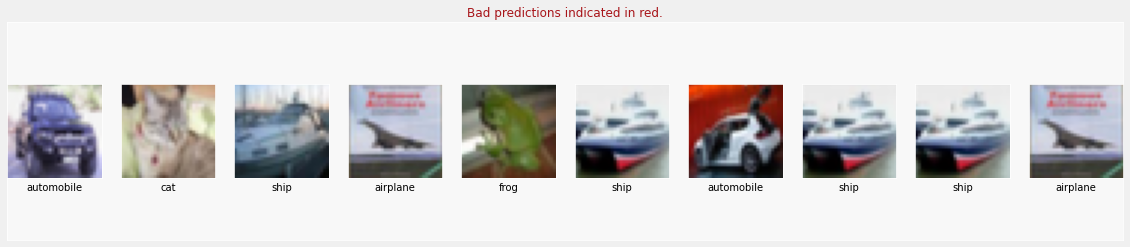

In [21]:
display_images(x_test[0:10], probabilities, y_test[0:10], "Bad predictions indicated in red.")

In [20]:
import os
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)